# design notes

## package name

This package is named "enjoyn" as a result of my enthusiasm for puns.

The name is a concoction of the words "enjoy" and "join", with a slight emphasis on the letter "n".

To elaborate, the goal of this package is "join"ing images to form animations, with the hope that users have an "enjoy"able experience, even if there are a "n" number of items to process.

## motivation

While developing [ahlive](https://ahlive.readthedocs.io/en/main/), it was awesome to see data come to life in lively animations.

What wasn't awesome was the animations taking a while to render, even though the frames were generated in parallel, but perhaps not in the best way.

Also, after `ahlive` was released, there was a user that asked [if they could use ahlive as a utility to display images in a sequence](https://github.com/ahuang11/ahlive/discussions/20).

The answer was no, but a year and a half later, it sparked a package idea to accomplish just that--`enjoyn`.

In the far future, I plan on building an `ahlive` 2.0 that uses `enjoyn` under the hood so data comes to life, quicker!

## musings

In `ahlive` I tried to accomplish everything within the machine's memory, without touching the storage disk until the very end.

The interpolated datasets were in memory, output frames were also in memory, saved as `BytesIO` objects.

I thought this was really slick, and after all, it's faster to read from memory than from disk, right?

This is true, but when working with multiple processes in parallel, it's actually beneficial to read/write from disk.

That's because ["moving data to remote processes and back can introduce performance penalties, particularly when the data being transferred between processes is large"](https://docs.dask.org/en/stable/scheduling.html).

Also, when data is on disk, threads, with relatively less overhead, can be used for I/O operations, or even for CLI subprocesses, like `gifsicle`.

## implementation

With what I learned from developing `ahlive`, `enjoyn` heavily relies on writing temporary files to disk.

`enjoyn` uses a map-reduce approach:
1. the `items` are grouped into partitions for workers to take on.
2. workers serialize the `items` into images, and write incomplete animations to disk.
3. with sufficient incomplete animations, workers start concatenating them into a more complete animation.
4. steps 2-3 are repeated until the animation is complete.
5. the final output is transferred to the desired `output_path`.

The schematic is shown below.
- step 2 is labeled `animate_images-part`.
- step 3 is labeled `concat-animations-aggregate`.
- step 5 is labeled `transfer_output`.

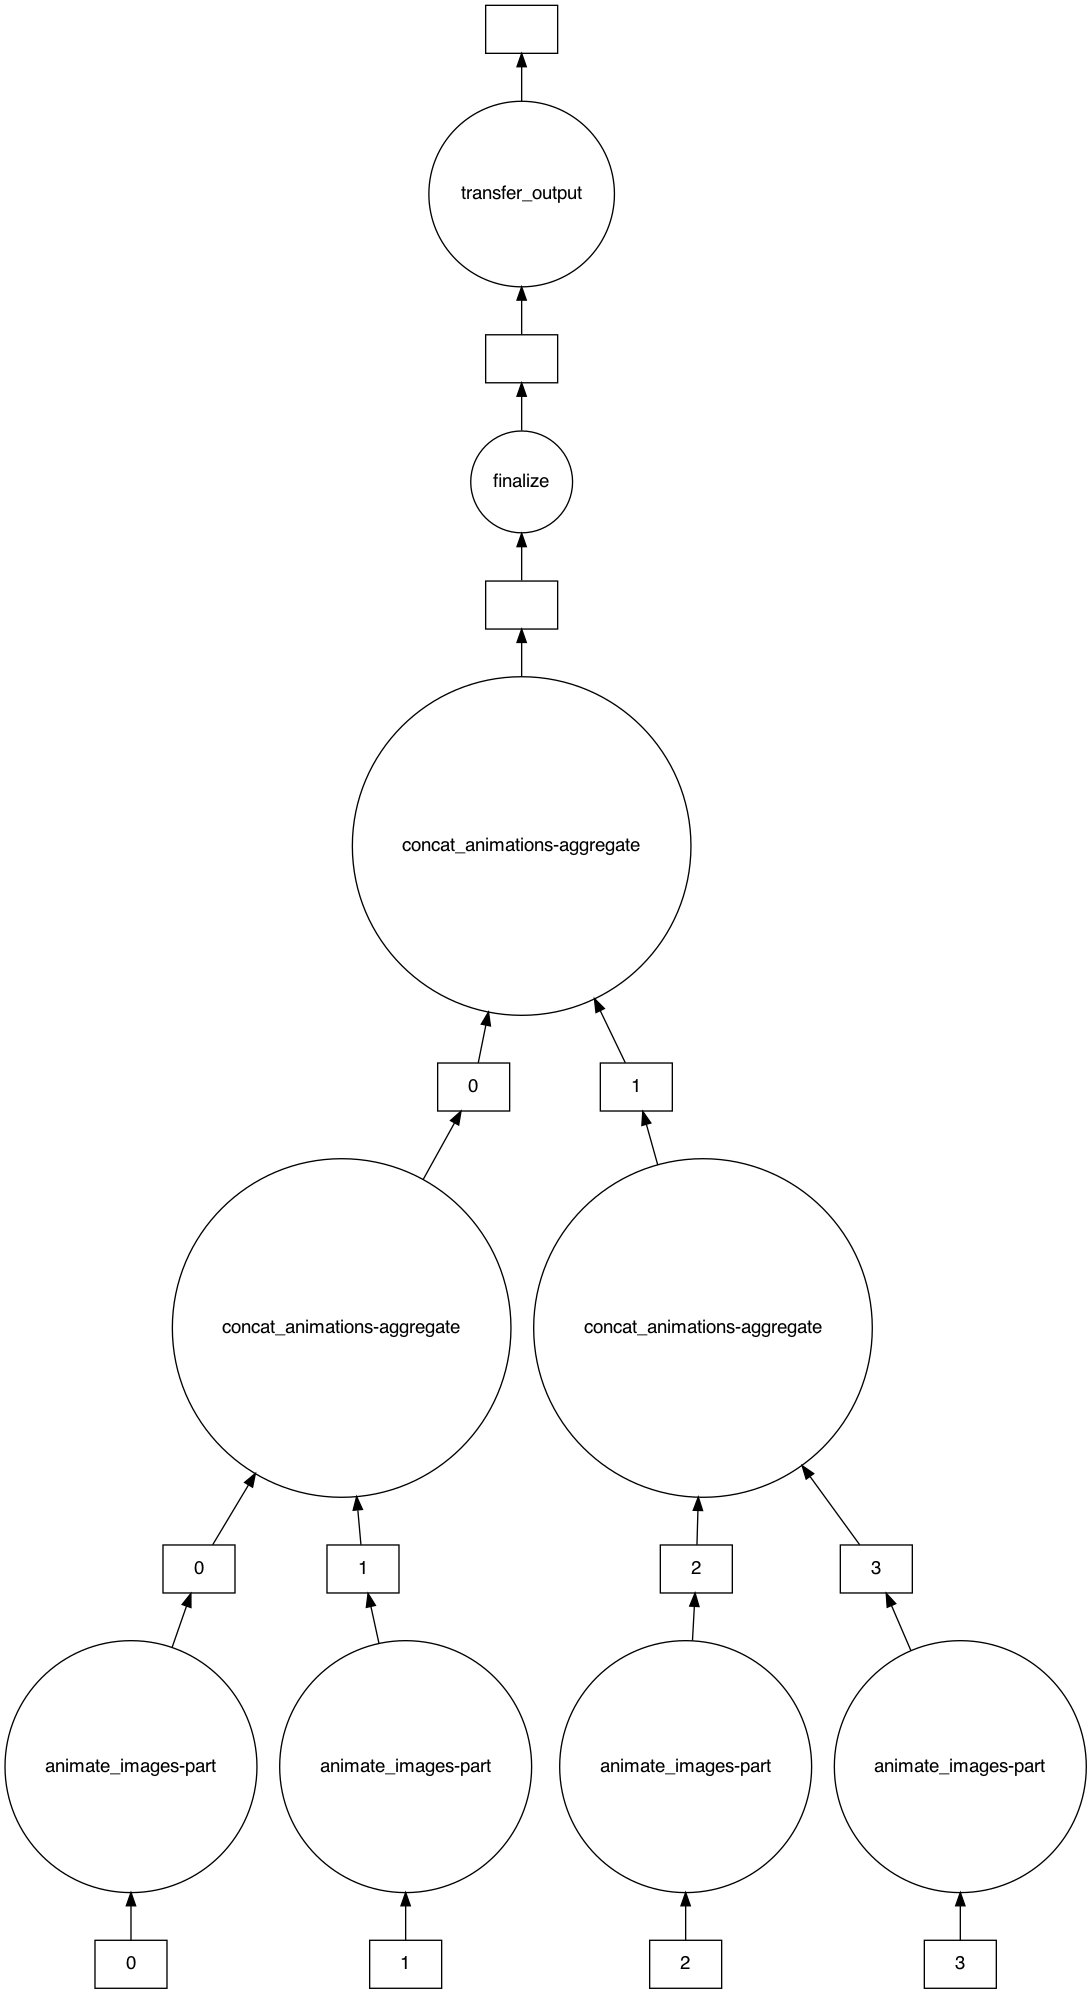

In [1]:
from enjoyn import GifAnimator
from enjoyn.example import RandomWalkExample

example = RandomWalkExample(length=100)
outputs = example.output_images()
animator = GifAnimator(items=outputs, output_path="random_walk.gif")
animator.plan(partition_size=25, split_every=2)